# Demo for RFIW-2020 (Task 2): Tri-Subject Verification
## Overview
Analysis and evaluation demo for tri-subject verification.

Here are a few tricks using [pandas](https://pandas.pydata.org) in the Recognizing Families In 
the Wild ([RFIW](https://web.northeastern.edu/smilelab/rfiw2020/)) data challenge. Specifically, in the tri-subject 
verification task ([Task-II](https://competitions.codalab.org/competitions/21843)).

We will evaluate pairs and perform analysis on the features used for assessment. Specifically, we will
- Load all features into dictionary.
- Evaluate according to verification protocol.
  - Calculate verification accuracies for the different relationship pair-types, along with the averaged accuracy.
  - Generate a ROC curve.
  - Visualize score distributions for KIN and NON-KIN for the different relationship types.

It is assumed features are extracted in are stored with the same name a image files, except as PKL files. The
demo loads all features into a dictionary with keys set as the image (face) name and path (i.e., FID/MID/faceID), but 
with the extension omitted. Thus, modifications can easily be made in data loading cell to fit the scheme in place if 
different.

For this, faces were encoded using SphereFace trained on MSCeleb in Pytorch (though any features can be plugged in).

No fine-tuning or special tricks were employed. This is solely to demonstrate a few simple steps for evaluation, followed
by easy to generate, yet appealing and insightful, visualizations of the feature embeddings.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns


import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [4]:
%matplotlib inline
# set styles for figures
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_style('whitegrid', {'font.family': 'serif',
                            'font.serif' : 'Times New Roman', 'fontsize': 18})

 Prepare file paths

In [14]:
dir_root = '../../data/rfiw2020-data/'

dir_data = dir_root + 'trisubject_verification/'
f_test_ref = dir_data + 'test_triples_reference.csv'
f_val_ref = dir_data + 'val_triplets_reference.csv'

dir_features = f'{dir_root}/FIDs-features/'

Load CSV files, feature file paths, and determine relationship types

In [15]:
df_val = pd.read_csv(f_val_ref)

# get all unique relationship types in DF
relationship_types = df_val.tag.unique()
print('Processing {} pairs of {} relationship types'.format(len(df_val), len(relationship_types)))

df_test = pd.read_csv(f_test_ref)

f_feats = np.unique(df_val.If.to_list() +
                    df_val.Im.to_list() + df_val.Ic.to_list())

Processing 3568 pairs of 2 relationship types


Load features

In [16]:
feats = {f: pd.read_pickle(dir_features + f.replace('.jpg', '.pkl')) for f in f_feats}


Determine cosine score for each pair. Do Father-Child and Mother-Child independently. Then, we will fuse
scores as the average of the two.

In [17]:
# score all feature pairs, because L2 norm applied on features dot is same as cosine sim
df_val['score_fc'] = df_val.apply(lambda x: np.dot(feats[x.If], feats[x.Ic].T), axis=1)
df_val['score_mc'] = df_val.apply(lambda x: np.dot(feats[x.Im], feats[x.Ic].T), axis=1)

df_val['score'] = df_val.apply(lambda x: (x.score_fc + x.score_mc)/2, axis=1)

In [18]:
df_val.head()

,If,Im,Ic,label,tag,FID,F,M,C,count,reversed_weights,score_fc,score_mc,score
0,F0007/MID1/P00073_face2.jpg,F0007/MID2/P00078_face2.jpg,F0007/MID6/P00074_face1.jpg,1,FMD,F0007,F0007/MID1,F0007/MID2,F0007/MID6,4,0.002803,-0.028150,0.004090,-0.012030
1,F0007/MID1/P00073_face2.jpg,F0007/MID2/P00081_face1.jpg,F0007/MID6/P00073_face3.jpg,1,FMD,F0007,F0007/MID1,F0007/MID2,F0007/MID6,4,0.002803,0.153014,0.265303,0.209159
2,F0007/MID1/P00077_face12.jpg,F0007/MID2/P00074_face0.jpg,F0007/MID4/P00074_face5.jpg,1,FMD,F0007,F0007/MID1,F0007/MID2,F0007/MID4,4,0.002803,0.165362,0.115922,0.140642
3,F0007/MID1/P00077_face12.jpg,F0007/MID2/P11277_face2.jpg,F0007/MID5/P00076_face0.jpg,1,FMD,F0007,F0007/MID1,F0007/MID2,F0007/MID5,4,0.002803,0.140530,0.380819,0.260674
4,F0007/MID1/P00079_face1.jpg,F0007/MID2/P00074_face0.jpg,F0007/MID4/P00074_face5.jpg,1,FMD,F0007,F0007/MID1,F0007/MID2,F0007/MID4,4,0.002803,0.114652,0.115922,0.115287


In [19]:
df_val.tail()

,If,Im,Ic,label,tag,FID,F,M,C,count,reversed_weights,score_fc,score_mc,score
3563,F0999/MID1/P10554_face0.jpg,F0999/MID4/P10558_face0.jpg,F0123/MID6/P01278_face1.jpg,0,FMS,F0999,F0999/MID1,F0999/MID4,F0123/MID6,5,0.002242,0.044601,-0.154332,-0.054866
3564,F0999/MID1/P10554_face0.jpg,F0999/MID4/P10558_face0.jpg,F0422/MID1/P04454_face3.jpg,0,FMS,F0999,F0999/MID1,F0999/MID4,F0422/MID1,5,0.002242,0.063158,-0.086713,-0.011777
3565,F0999/MID1/P10554_face0.jpg,F0999/MID4/P10552_face1.jpg,F0438/MID6/P04637_face1.jpg,0,FMS,F0999,F0999/MID1,F0999/MID4,F0438/MID6,5,0.002803,-0.079974,-0.026765,-0.053370
3566,F1004/MID2/P13032_face0.jpg,F1004/MID1/P13035_face0.jpg,F0283/MID5/P03026_face0.jpg,0,FMS,F1004,F1004/MID2,F1004/MID1,F0283/MID5,5,0.000561,0.136953,0.021686,0.079320
3567,F1004/MID2/P13033_face0.jpg,F1004/MID1/P13033_face2.jpg,F0826/MID3/P08740_face10.jpg,0,FMS,F1004,F1004/MID2,F1004/MID1,F0826/MID3,5,0.000561,-0.013962,0.037142,0.011590


In [20]:
df_val['label']=df_val['label'].astype(np.uint)
fpr, tpr, threshold = roc_curve(df_val['label'], df_val['score'])

auc = roc_auc_score(df_val['label'], df_val['score'])

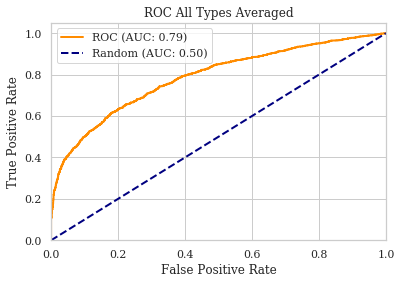

In [21]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (AUC: %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC: 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC All Types Averaged')
plt.legend(loc="best")
plt.show()

Next plot signal detection models (SDM) for each relationship type. From this, the distribution of scores as a 
function of label (i.e., KIN vs NON-KIN) can be compared.

<Figure size 432x288 with 0 Axes>

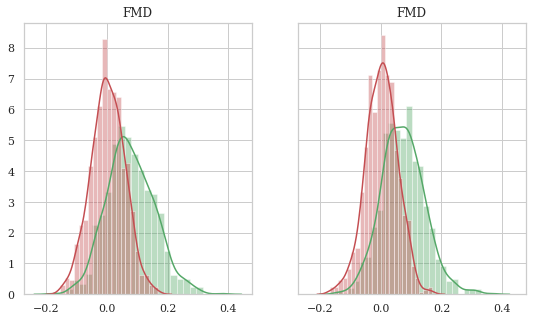

In [24]:
sns.despine(left=True)

f, axs = plt.subplots(1, 2,figsize=(9,5), sharex=True, sharey=True)

for i in range(len(relationship_types)):
    df_cur = df_val.loc[df_val.tag == relationship_types[i],['score', 'label']]
    sns.distplot(df_cur.loc[df_cur.label==1,'score'],hist=True, label='True',ax=axs[i],color='g')
    sns.distplot(df_cur.loc[df_cur.label==0,'score'], hist=True,label='False',ax=axs[i],color='r')
    axs[i].set_title(relationship_types[0])
    axs[i].set_xlabel('')
    
axs[0].set_ylabel('Frequency')

Similar to SDM, but let's look at boxen plots as means of another visualization of two-class separability.